In [1]:
from phasenet.model import PhaseNet, Config, Data
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

2022-10-10 15:41:28.136150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 15:41:28.256379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 15:41:28.256400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-10 15:41:28.282617: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-10 15:41:28.838307: W tensorflow/stream_executor/platform/de

GPU Tools False


## The phasenet model can be trained using the following three steps: 

### STEP 1 : Setup the config

In [2]:
from IPython.display import Markdown
import re
hlp = '### ' + Config.__doc__
def _replace(s):
    return f"  \n\n`{s.group(1).strip()}`: "
hlp = re.sub(r'\n\s*:param([^:]+):', _replace, hlp)
display(Markdown(hlp))

### Configuration for phasenet models  

`zernike_amplitude_ranges`:  dictionary or list, the values should either a scalar indicating the absolute magnitude
            or a tuple with upper and lower bound, default is {'vertical coma': (-0.2,0.2)}  

`zernike_order`:  string, Zernike nomenclature used when the amplitude ranges are given as a list, default is 'noll'  

`zernike_normed`:  Boolean, whether the Zernike are normalized according, default is True  

`net_architecture`:  convnet or resnet, default is convnet  

`net_kernel_size`:  convolution kernel size, default is (3,3,3)  

`net_pool_size`:  max pool kernel size, default is (1,2,2)  

`net_activation`:  activation, default is 'tanh'  

`net_padding`:  padding for convolution, default is 'same'  

`psf_shape`:  tuple, shpae of the psf, default is (64,64,64)  

`psf_units`:  tuple, voxel unit (z,y,x) in um, default is (0.1,0.1,0.1)  

`psf_na_detection`:  scalar, numerical aperture default is 1.1  

`psf_lam_detection`:  scalar, wavelength in um, default is 0.5  

`psf_n`:  scalar, refractive index of immersion medium, default is 1.33  

`noise_snr`:  scalar or tuple, signal to noise ratio  

`noise_mean`:  scalar or tuple, mean background noise  

`noise_sigma`:  scalar or tuple, sigma for Gaussian noise  

`gaussian_blur_sigma`:  float, sigma for Gaussian blurring after adding noise, default is None  

`phantom_params`:  dictionary, parameters for the chosen phantom, e.g. {'name':'sphere','radius':0.1}  

`crop_shape`:  tuple, crop shape  

`jitter`:  Boolean, randomly move the center point within a given limit, default is False  

`max_jitter`:  tuple, maximum displacement for jitter, if None then it gets a default value  

`train_loss`:  string, training loss, default is 'mse'  

`train_epochs`:  integer, number of epochs for training, default is 400  

`train_steps_per_epoch`:  integer, number of steps per epoch, default is 5  

`train_learning_rate`:  scalar, leaning rate, default is 0.0003  

`train_batch_size`:  integer, batch size for training the network, default is 8  

`train_n_val`:  integer, number of validation data, default is 128  

`train_tensorboard`:  boolean, create tensor-board, default is True  

`planes`:  list, z planes with respect to center, if None then it takes all the planes

    

### Important parameters

- Please set the Zernike modes for your application (i.e. which modes in what ranges should the neural network be able to predict) by changing the parameter `zernike_amplitude_ranges`. Please modify `zernike_order` if the Zernikes are not provided in Noll index.

- It is also important to set the PSF parameters (`psf_lam_detection`, `psf_units`, `psf_na_detection`, `psf_n`) to match the physical properties of the microscope being used.

- It is also advisable to set the noise characteristics (`noise_mean`, `noise_sigma`, `noise_snr`) and phantom parameters (`phantom_params`) to match your image acquisition setup.

- The training and network parameters (`train_*`, `net_*`) likely don't have to be changed.

In [3]:
#zern = [5,6,7,8,9,10,11,12,13,14,15] # for final training
zern = [5]                            # for trial
amp_range = [0.15]*len(zern)
amps = dict(zip(zern, amp_range))

In [5]:
c = Config(zernike_amplitude_ranges=amps, psf_na_detection=1.1, psf_units=(0.1,0.086,0.086), psf_n=1.33, psf_lam_detection=0.515, noise_mean=None, noise_snr=None, noise_sigma=None)
vars(c)

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'zernike_amplitude_ranges': {5: 0.15},
 'zernike_order': 'noll',
 'zernike_normed': True,
 'net_architecture': 'convnet',
 'net_kernel_size': (3, 3, 3),
 'net_pool_size': (1, 2, 2),
 'net_activation': 'tanh',
 'net_padding': 'same',
 'psf_shape': (64, 64, 64),
 'psf_units': (0.1, 0.086, 0.086),
 'psf_na_detection': 1.1,
 'psf_lam_detection': 0.515,
 'psf_n': 1.33,
 'noise_mean': None,
 'noise_sigma': None,
 'noise_snr': None,
 'noise_perlin_flag': False,
 'gaussian_blur_sigma': None,
 'phantom_params': {'name': 'points', 'num': 1},
 'crop_shape': (32, 32, 32),
 'jitter': True,
 'max_jitter': None,
 'planes': None,
 'train_loss': 'mse',
 'train_epochs': 400,
 'train_steps_per_epoch': 5,
 'train_learning_rate': 0.0003,
 'train_batch_size': 8,
 'train_n_val': 128,
 'train_tensorboard': True

## STEP 2 : Setup the model

In [6]:
model = PhaseNet(config=c, name='test', basedir='models')

2022-10-10 15:42:48.129685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-10 15:42:48.129717: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-10 15:42:48.129742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gurb): /proc/driver/nvidia/version does not exist
2022-10-10 15:42:48.129971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## STEP 3: Train the model

**Note**: We only set `epochs=20` here for a quick demo. Remove that to train the model properly (will take much longer).

In [7]:
model.train(epochs=20)

/users/srio/miniconda3/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/nobackup/gurb1/srio/OASYS1.2/phasenet/phasenet/psf.py:49: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(1. * self.n ** 2 - KR3 ** 2 * lam_detection ** 2)
/nobackup/gurb1/srio/OASYS1.2/phasenet/phasenet/model.py:458: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  callbacks=self.callbacks, verbose=1)


Epoch 1/20
5/5 [==============================] - 7s 1s/step - loss: 0.0157 - val_loss: 0.0038
Epoch 2/20
5/5 [==============================] - 5s 1s/step - loss: 0.0024 - val_loss: 0.0017
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 0.0017 - val_loss: 0.0013
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 0.0016 - val_loss: 7.7011e-04
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 8.7331e-04 - val_loss: 4.6097e-04
Epoch 6/20
5/5 [==============================] - 5s 1s/step - loss: 5.0280e-04 - val_loss: 6.4707e-04
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 3.7796e-04 - val_loss: 4.5370e-04
Epoch 8/20
5/5 [==============================] - 5s 1s/step - loss: 4.8727e-04 - val_loss: 4.6794e-04
Epoch 9/20
5/5 [==============================] - 6s 1s/step - loss: 5.2638e-04 - val_loss: 5.0992e-04
Epoch 10/20
5/5 [==============================] - 6s 1s/step - loss: 6.7462e-04 - val_loss: 4.4278e-

### Validation on synthetic data

In [8]:
data = Data(
    batch_size           = 50,
    amplitude_ranges     = model.config.zernike_amplitude_ranges,
    order                = model.config.zernike_order,
    normed               = model.config.zernike_normed,
    psf_shape            = model.config.psf_shape,
    units                = model.config.psf_units,
    na_detection         = model.config.psf_na_detection,
    lam_detection        = model.config.psf_lam_detection,
    n                    = model.config.psf_n,
    noise_mean           = model.config.noise_mean,
    noise_snr            = model.config.noise_snr,
    noise_sigma          = model.config.noise_sigma,
    noise_perlin_flag    = model.config.noise_perlin_flag,
    crop_shape           = model.config.crop_shape,
    jitter               = model.config.jitter,
    phantom_params       = model.config.phantom_params,
    planes               = model.config.planes,
)
psfs, amps = next(data.generator())
psfs.shape, amps.shape

((50, 32, 32, 32, 1), (50, 1))

In [20]:
amps_pred = np.array([model.predict(psf) for psf in tqdm(psfs)])

100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


NameError: name 'amps_pred' is not defined

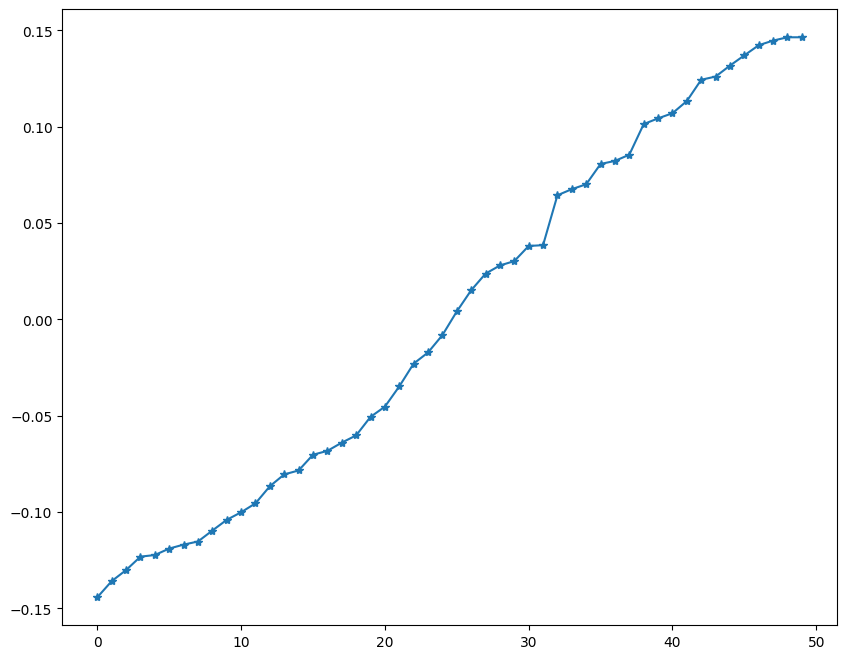

In [9]:
plt.figure(figsize=(10,8))
ind = np.argsort(amps.ravel())
plt.plot(amps[ind], marker='*', label='gt')
plt.plot(amps_pred[ind], '--', marker='*', label='pred')
# plt.hlines(-0.2, *plt.axis()[:2])
# plt.hlines(+0.2, *plt.axis()[:2])
plt.xlabel('test psf')
plt.ylabel(f'amplitude {tuple(model.config.zernike_amplitude_ranges.keys())[0]}')
plt.legend()
None;